In [31]:
from nptdms import TdmsFile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime


path_main_folder = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne"
path_annotation_folder = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Seizure log ePatch patients with seizures"
path_patients_folder = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data"



In [3]:
# Load through all patient folders
for patient_folder in os.listdir(path_patients_folder):
    patient_path = os.path.join(path_patients_folder, patient_folder)
    if os.path.isdir(patient_path):
        print(f"Processing patient folder: {patient_folder}")
        for recording_folder in os.listdir(patient_path):
            recording_path = os.path.join(patient_path, recording_folder)
            if os.path.isdir(recording_path):
                print(f"  Processing recording folder: {recording_folder}")
                # if folder name contains 'enrollment' (case-insensitive) search one level deeper
                if 'enrollment' in recording_folder.lower() or 'enrollment' in recording_path.lower():
                    for subfolder in os.listdir(recording_path):
                        sub_path = os.path.join(recording_path, subfolder)
                        if os.path.isdir(sub_path):
                            print(f"    Entering enrollment subfolder: {subfolder}")
                            for file_name in os.listdir(sub_path):
                                if file_name.endswith('.tdms'):
                                    file_path = os.path.join(sub_path, file_name)
                                    print(f"      Found TDMS file: {file_name}")
                                    patient_number = file_name.split('_')
                                    print(f"      Patient number extracted: {patient_number[0]}")
                                    # Here you can add code to process each TDMS file as needed
                else:
                    for file_name in os.listdir(recording_path):
                        if file_name.endswith('.tdms'):
                            file_path = os.path.join(recording_path, file_name)
                            print(f"    Found TDMS file: {file_name}")
                            patient_number = file_name.split('_')
                            print(f"    Patient number extracted: {patient_number[0]}")
                            # Here you can add code to process each TDMS file as needed

Processing patient folder: Patient 1
  Processing recording folder: recording 1
    Found TDMS file: Patient 1_1.tdms
    Patient number extracted: Patient 1
  Processing recording folder: recording 2
    Found TDMS file: Patient 1_2.tdms
    Patient number extracted: Patient 1
Processing patient folder: Patient 10
  Processing recording folder: recording 1
    Found TDMS file: Patient 10_1.tdms
    Patient number extracted: Patient 10
Processing patient folder: Patient 11
  Processing recording folder: recording 1
    Found TDMS file: Patient 11_1.tdms
    Patient number extracted: Patient 11
  Processing recording folder: recording 2
    Found TDMS file: Patient 11_2.tdms
    Patient number extracted: Patient 11
Processing patient folder: Patient 12
  Processing recording folder: recording 1
    Found TDMS file: Patient 12_1.tdms
    Patient number extracted: Patient 12
  Processing recording folder: recording 2
    Found TDMS file: Patient 12_2.tdms
    Patient number extracted: Pat

In [5]:
patients_responders_numbers = [3,5,6,8,10,14,15,16,21,23,27,28,29,31,34,37,39,40,41,42]
patients_responders = [f"Patient {num}" for num in patients_responders_numbers]
# print("Responders:", patients_responders)

In [25]:
import os
import re

def _parse_time_cell(date_cell, time_cell):
    """
    Combine a date cell and a time cell into a pandas.Timestamp.
    Returns pd.NaT if either is missing or cannot be parsed.
    Handles:
      - time as Excel fraction (float)
      - time as pandas.Timestamp / datetime / time
      - time as string like 'HH:MM:SS'
    """
    if pd.isna(time_cell) or pd.isna(date_cell):
        return pd.NaT

    date_ts = pd.to_datetime(date_cell, errors='coerce')
    if pd.isna(date_ts):
        return pd.NaT
    date_norm = date_ts.normalize()

    # numeric (Excel time fraction)
    if isinstance(time_cell, (int, float, np.integer, np.floating)):
        # fraction of day -> timedelta
        return date_norm + pd.to_timedelta(float(time_cell), unit='D')

    # pandas Timestamp or datetime
    if isinstance(time_cell, pd.Timestamp):
        t = time_cell
        return date_norm + pd.to_timedelta(t.hour, unit='h') + pd.to_timedelta(t.minute, unit='m') + pd.to_timedelta(t.second, unit='s') + pd.to_timedelta(t.microsecond, unit='us')

    if isinstance(time_cell, datetime.datetime):
        t = time_cell
        return date_norm + pd.to_timedelta(t.hour, unit='h') + pd.to_timedelta(t.minute, unit='m') + pd.to_timedelta(t.second, unit='s') + pd.to_timedelta(t.microsecond, unit='us')

    if isinstance(time_cell, datetime.time):
        return datetime.datetime.combine(date_norm.date(), time_cell)

    # fallback: try parsing string
    s = str(time_cell).strip()
    if s == '' or s.lower() in {'nan', 'none', 'na'}:
        return pd.NaT
    parsed = pd.to_datetime(s, errors='coerce')
    if pd.isna(parsed):
        return pd.NaT
    return date_norm + pd.to_timedelta(parsed.hour, unit='h') + pd.to_timedelta(parsed.minute, unit='m') + pd.to_timedelta(parsed.second, unit='s') + pd.to_timedelta(parsed.microsecond, unit='us')


def _seconds_since_midnight(ts):
    if pd.isna(ts):
        return np.nan
    return ts.hour * 3600 + ts.minute * 60 + ts.second + ts.microsecond / 1e6


def load_seizure_annotations_file(path_excel):
    """
    Load a single Excel annotation file where the table header is on row 7 (use header=6).
    Expected columns (any reasonable variant/casing):
      - Seizure number
      - Date
      - Seizurestart clinic (tt:mm:ss)
      - Seizurestart EEG (tt:mm:ss)
      - Seizureend clinic (tt:mm:ss)
      - Seizureend EEG (tt:mm:ss)
      - Seizure type
      - other

    Returns a DataFrame with:
      seizure_number, date (normalized), start_clinic, start_eeg, end_clinic, end_eeg,
      seizure_type, other, and helper columns with seconds_since_midnight and hour for starts/ends.
    """
    df = pd.read_excel(path_excel, header=6)
    # normalize column names
    cols = {c: str(c).strip() for c in df.columns}
    df.rename(columns=cols, inplace=True)

    def find_col(key):
        key_l = key.lower()
        for c in df.columns:
            if key_l in c.lower():
                return c
        return None

    num_col = find_col('Anfald nr') or find_col('seizure')
    date_col = find_col('Dato')
    s_clin_col = find_col('Anfaldsstart Klinisk') or find_col('Anfaldsstart klinisk')
    s_eeg_col = find_col('Anfaldsstart EEG') or find_col('Anfaldsstart eeg')
    e_clin_col = find_col('Anfaldstop Klinisk') or find_col('Anfaldstop klinisk')
    e_eeg_col = find_col('Anfaldstop EEG') or find_col('Anfaldstop eeg')
    type_col = find_col('Anfaldstype') or find_col('anfaldstype')
    other_col = find_col('Evt. bemærkninger') or find_col('note') or find_col('other')

    res = pd.DataFrame()
    res['seizure_number'] = df[num_col] if num_col else df.index + 1
    # normalize date column to midnight timestamps
    if date_col:
        res['date'] = pd.to_datetime(df[date_col], errors='coerce').dt.normalize()
    else:
        res['date'] = pd.NaT

    # combine date + time for each time column
    res['start_clinic'] = df.apply(lambda r: _parse_time_cell(r[date_col], r[s_clin_col]) if s_clin_col else pd.NaT, axis=1)
    res['start_eeg'] = df.apply(lambda r: _parse_time_cell(r[date_col], r[s_eeg_col]) if s_eeg_col else pd.NaT, axis=1)
    res['end_clinic'] = df.apply(lambda r: _parse_time_cell(r[date_col], r[e_clin_col]) if e_clin_col else pd.NaT, axis=1)
    res['end_eeg'] = df.apply(lambda r: _parse_time_cell(r[date_col], r[e_eeg_col]) if e_eeg_col else pd.NaT, axis=1)

    # copy type/other if present
    res['seizure_type'] = df[type_col] if type_col else None
    res['other'] = df[other_col] if other_col else None

    # helper columns for statistics (seconds since midnight and hour)
    for prefix in ['start_clinic', 'start_eeg', 'end_clinic', 'end_eeg']:
        res[f'{prefix}_seconds'] = res[prefix].apply(_seconds_since_midnight)
        res[f'{prefix}_hour'] = res[prefix].dt.hour

    # keep original source filename for traceability
    res['source_file'] = os.path.basename(path_excel)

    return res


def load_seizure_annotations_folder(folder_path, pattern_exts=('.xlsx', '.xls')):
    """
    Load all annotation Excel files in a folder and concatenate them into a single DataFrame.
    Adds a column 'source_file' so you can identify the origin of each row.
    """
    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(pattern_exts)]
    parts = []
    for f in files:
        try:
            parts.append(load_seizure_annotations_file(f))
        except Exception as e:
            # skip problematic files but warn in output
            print(f"Warning: failed to load {f}: {e}")
    if parts:
        return pd.concat(parts, ignore_index=True)
    return pd.DataFrame()  # empty

def load_responders_annotations(responders=None, folder=path_annotation_folder, exts=('.xls', '.xlsx')):
    """
    Load annotation Excel files for the patients in `responders`.
    - responders: list like ['Patient 3', 'Patient 34', ...] or list of ints. If None uses patients_responders.
    - folder: path to annotation files (default: path_annotation_folder).
    - exts: tuple of accepted file extensions.
    Returns: (DataFrame, list_of_loaded_files)
    """

    if responders is None:
        responders = patients_responders

    # list candidate files
    files = [f for f in os.listdir(folder) if f.lower().endswith(exts)]
    parts = []
    loaded = []

    for resp in responders:
        resp_str = str(resp).strip()
        # try to extract numeric patient id if present
        m = re.search(r'(\d+)', resp_str)
        if m:
            num = m.group(1)
            # match "Patient <num>" at start, but avoid matching "Patient 31" when num=3
            pattern = re.compile(r'^patient\s*' + re.escape(num) + r'(?!\d)', re.I)
            matches = [f for f in files if pattern.search(f)]
        else:
            # fallback: substring-match case-insensitive
            pattern = re.compile(re.escape(resp_str), re.I)
            matches = [f for f in files if pattern.search(f)]

        for fname in matches:
            fpath = os.path.join(folder, fname)
            try:
                parts.append(load_seizure_annotations_file(fpath))
                loaded.append(fname)
            except Exception as e:
                print(f"Warning: failed to load {fname}: {e}")

    if parts:
        return pd.concat(parts, ignore_index=True), list(dict.fromkeys(loaded))
    return pd.DataFrame(), []


# Example usage (in notebook cell):
# ann = load_seizure_annotations_file(r"path\to\annotation_file.xlsx")
# or to load all:
# all_ann = load_seizure_annotations_folder(path_annotation_folder)

In [17]:
ann = load_seizure_annotations_file(r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Seizure log ePatch patients with seizures\Patient 3.xls")

In [18]:
print(ann.head())

   seizure_number       date        start_clinic start_eeg  \
0               1 2016-05-09 2016-05-09 23:20:06       NaT   
1               2 2016-06-09 2016-06-09 23:22:04       NaT   
2               3 2016-07-09 2016-07-09 15:13:52       NaT   

           end_clinic end_eeg  seizure_type  other  start_clinic_seconds  \
0 2016-05-09 23:20:32     NaT           NaN    NaN               84006.0   
1 2016-06-09 23:22:31     NaT           NaN    NaN               84124.0   
2 2016-07-09 15:14:30     NaT           NaN    NaN               54832.0   

   start_clinic_hour  start_eeg_seconds  start_eeg_hour  end_clinic_seconds  \
0                 23                NaN             NaN             84032.0   
1                 23                NaN             NaN             84151.0   
2                 15                NaN             NaN             54870.0   

   end_clinic_hour  end_eeg_seconds  end_eeg_hour    source_file  
0               23              NaN           NaN  Patient 3.x

In [ ]:
ann_all = load_seizure_annotations_folder(path_annotation_folder)

C:\Users\kvjkv\AppData\Local\Temp\ipykernel_18088\3337078172.py:93: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  res['date'] = pd.to_datetime(df[date_col], errors='coerce').dt.normalize()
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_18088\3337078172.py:93: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  res['date'] = pd.to_datetime(df[date_col], errors='coerce').dt.normalize()
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_18088\3337078172.py:13: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  date_ts = pd.to_datetime(date_cell, errors='coerce')
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_18088\3337078172.py:13: UserWarning: 

Loaded total of 357 seizure annotations from folder.


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_18088\3337078172.py:93: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  res['date'] = pd.to_datetime(df[date_col], errors='coerce').dt.normalize()


In [ ]:
print(f"Loaded total of {len(ann_all)} seizure annotations from folder.")

print(ann_all.head())

# show overall structure and counts per patient file
print("Columns:", ann_all.columns.tolist())
print("\nInfo:")
ann_all.info()
print("\nCounts per source_file (patients):")
print(ann_all['source_file'].value_counts())

# list unique patient source files
patients = ann_all['source_file'].dropna().unique()
print("\nUnique patient files (sample):", patients[:20])

# Example: get all seizures for Patient 9 (match by substring)
patient_name = 'Patient 9'
patient_rows = ann_all[ann_all['source_file'].str.contains(patient_name, na=False)]
print(f"\nSeizures for '{patient_name}': {len(patient_rows)} rows")
print(patient_rows.head())

# Alternative: build a dict keyed by exact source_file for fast access
by_patient = {k: g for k, g in ann_all.groupby(ann_all['source_file'].fillna(''))}
key = 'Patient 9.xls'   # adjust to exact filename present in source_file
if key in by_patient:
    print(f"\nExact key '{key}' has {len(by_patient[key])} rows")
    print(by_patient[key].head())
else:
    print(f"\nExact key '{key}' not found; sample keys:", list(by_patient.keys())[:10])

Loaded total of 357 seizure annotations from folder.
  seizure_number       date        start_clinic           start_eeg  \
0              1 2016-02-23 2016-02-23 23:14:01                 NaT   
1              2 2016-02-25 2016-02-25 05:20:48 2016-02-25 05:21:03   
2              3 2016-02-26 2016-02-26 05:30:53 2016-02-26 05:31:20   
3              1 2017-08-17                 NaT                 NaT   
4              2 2017-08-17                 NaT                 NaT   

           end_clinic             end_eeg      seizure_type  \
0 2016-02-23 23:14:42                 NaT   komleks partiel   
1 2016-02-25 05:22:20 2016-02-25 05:21:25  kompleks partiel   
2 2016-02-26 05:31:34 2016-02-26 05:31:50  kompleks partiel   
3                 NaT                 NaT      Fokal anfald   
4                 NaT                 NaT      Fokal anfald   

                                               other  start_clinic_seconds  \
0         gelastisk, EEG ubedømmelig pga. artefakter           

In [42]:
# Compute statistics about seizures and night-time occurrences (22:00-07:00)
df = ann_all  # use existing dataframe

# Columns considered for presence of timing information
time_cols = ['start_clinic', 'start_eeg', 'end_clinic', 'end_eeg']

# Exclude seizures where all start/end times are NaN
mask_all_times_missing = df[time_cols].isna().all(axis=1)
excluded_count = int(mask_all_times_missing.sum())
total_count = len(df)
included_df = df[~mask_all_times_missing].copy()
included_count = len(included_df)

# For determining start time, prefer start_eeg, then start_clinic, then end_eeg, then end_clinic
def _choose_start_ts(row):
    for c in ['start_eeg', 'start_clinic', 'end_eeg', 'end_clinic']:
        v = row.get(c)
        if pd.notna(v):
            return v
    return pd.NaT

included_df['best_start'] = included_df.apply(_choose_start_ts, axis=1)
included_df['best_start_hour'] = included_df['best_start'].dt.hour

# prefer EEG times, otherwise clinic times; compute durations where both start+end available
starts = included_df['start_eeg'].fillna(included_df['start_clinic'])
ends   = included_df['end_eeg'].fillna(included_df['end_clinic'])
included_df['duration_s'] = (ends - starts).dt.total_seconds()

# count seizures with valid duration and those >20s
n_with_duration = int(included_df['duration_s'].notna().sum())
n_over_20s = int((included_df['duration_s'] > 20).sum())

print(f"Seizures with valid duration: {n_with_duration}")
print(f"Seizures with duration > 20 s: {n_over_20s}")

# Night definition: hour >= 22 OR hour < 7
night_mask = included_df['best_start_hour'].notna() & ((included_df['best_start_hour'] >= 22) | (included_df['best_start_hour'] < 7))
night_count = int(night_mask.sum())

# Percentages
pct_excluded = excluded_count / total_count * 100 if total_count else 0.0
pct_night_of_included = night_count / included_count * 100 if included_count else 0.0
pct_night_of_total = night_count / total_count * 100 if total_count else 0.0

# Print summary
print(f"Total seizure rows: {total_count}")
print(f"Excluded (all start/end times missing): {excluded_count} ({pct_excluded:.1f}%)")
print(f"Included (has at least one start/end time): {included_count}")
print(f"Seizures starting during night (22:00-07:00): {night_count}")
print(f" - As % of included seizures: {pct_night_of_included:.1f}%")
print(f" - As % of all seizure rows: {pct_night_of_total:.1f}%")

# Optional: breakdown per patient (source_file) — show only patients with >=1 included seizure
per_patient = included_df.groupby('source_file').apply(
    lambda g: pd.Series({
        'n_included': len(g),
        'n_night': int(((g['best_start'].dt.hour >= 22) | (g['best_start'].dt.hour < 7)).sum()),
    })
).sort_values('n_included', ascending=False)

# Add percentage column
per_patient['pct_night'] = per_patient['n_night'] / per_patient['n_included'] * 100
print("\nPer-patient breakdown (patients with included seizures):")
print(per_patient.head(40))  # show up to 40 patients

Seizures with valid duration: 146
Seizures with duration > 20 s: 102
Total seizure rows: 357
Excluded (all start/end times missing): 203 (56.9%)
Included (has at least one start/end time): 154
Seizures starting during night (22:00-07:00): 83
 - As % of included seizures: 53.9%
 - As % of all seizure rows: 23.2%

Per-patient breakdown (patients with included seizures):
                  n_included  n_night   pct_night
source_file                                      
Patient 31a.xlsx          28        4   14.285714
Patient 13.xls            18       18  100.000000
Patient 2.xls              8        8  100.000000
Patient 14.xls             7        5   71.428571
Patient 39.xls             7        4   57.142857
Patient 20.xlsx            6        6  100.000000
Patient 21.xlsx            5        0    0.000000
Patient 35.xls             5        4   80.000000
Patient 32.xls             4        1   25.000000
Patient 31b.xls            3        2   66.666667
Patient 36.xls             3 

C:\Users\kvjkv\AppData\Local\Temp\ipykernel_18088\3945576348.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_patient = included_df.groupby('source_file').apply(


In [ ]:
# load_responder_annotations returns (DataFrame, list_of_loaded_files)
ann_responders, ann_responders_files = load_responders_annotations(responders=patients_responders, folder=path_annotation_folder)

C:\Users\kvjkv\AppData\Local\Temp\ipykernel_18088\3297211601.py:96: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  res['date'] = pd.to_datetime(df[date_col], errors='coerce').dt.normalize()
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_18088\3297211601.py:96: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  res['date'] = pd.to_datetime(df[date_col], errors='coerce').dt.normalize()
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_18088\3297211601.py:16: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  date_ts = pd.to_datetime(date_cell, errors='coerce')
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_18088\3297211601.py:16: UserWarning: 

195   seizure_number       date        start_clinic           start_eeg  \
0              1 2016-05-09 2016-05-09 23:20:06                 NaT   
1              2 2016-06-09 2016-06-09 23:22:04                 NaT   
2              3 2016-07-09 2016-07-09 15:13:52                 NaT   
3              1 2016-10-13 2016-10-13 07:26:57 2016-10-13 07:26:31   
4              2 2016-10-13 2016-10-13 14:47:50 2016-10-13 14:47:29   

           end_clinic             end_eeg      seizure_type other  \
0 2016-05-09 23:20:32                 NaT               NaN   NaN   
1 2016-06-09 23:22:31                 NaT               NaN   NaN   
2 2016-07-09 15:14:30                 NaT               NaN   NaN   
3 2016-10-13 07:28:57 2016-10-13 07:26:58  kompleks partiel   NaN   
4 2016-10-13 14:49:23 2016-10-13 14:49:24  kompleks partiel   NaN   

   start_clinic_seconds  start_clinic_hour  start_eeg_seconds  start_eeg_hour  \
0               84006.0               23.0                NaN            

C:\Users\kvjkv\AppData\Local\Temp\ipykernel_18088\3297211601.py:96: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  res['date'] = pd.to_datetime(df[date_col], errors='coerce').dt.normalize()
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_18088\3297211601.py:96: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  res['date'] = pd.to_datetime(df[date_col], errors='coerce').dt.normalize()
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_18088\3297211601.py:96: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  res['date'] = pd.to_datetime(df[date_col], errors='coerce').dt.normalize()


In [32]:
print(len(ann_responders), ann_responders.head())
print("Loaded responder files:", ann_responders_files)

195   seizure_number       date        start_clinic           start_eeg  \
0              1 2016-05-09 2016-05-09 23:20:06                 NaT   
1              2 2016-06-09 2016-06-09 23:22:04                 NaT   
2              3 2016-07-09 2016-07-09 15:13:52                 NaT   
3              1 2016-10-13 2016-10-13 07:26:57 2016-10-13 07:26:31   
4              2 2016-10-13 2016-10-13 14:47:50 2016-10-13 14:47:29   

           end_clinic             end_eeg      seizure_type other  \
0 2016-05-09 23:20:32                 NaT               NaN   NaN   
1 2016-06-09 23:22:31                 NaT               NaN   NaN   
2 2016-07-09 15:14:30                 NaT               NaN   NaN   
3 2016-10-13 07:28:57 2016-10-13 07:26:58  kompleks partiel   NaN   
4 2016-10-13 14:49:23 2016-10-13 14:49:24  kompleks partiel   NaN   

   start_clinic_seconds  start_clinic_hour  start_eeg_seconds  start_eeg_hour  \
0               84006.0               23.0                NaN            

In [45]:
# Recalculate statistics using the responders' annotations
# Use ann_responders if available, otherwise fall back to ann_all
df = ann_responders if 'ann_responders' in globals() and isinstance(ann_responders, pd.DataFrame) else ann_all
time_cols = ['start_clinic', 'start_eeg', 'end_clinic', 'end_eeg']

# Exclude rows where all time columns are missing
mask_all_times_missing = df[time_cols].isna().all(axis=1)
excluded_count = int(mask_all_times_missing.sum())
total_count = len(df)
included_df = df[~mask_all_times_missing].copy()
included_count = len(included_df)

# Choose best start timestamp with priority: start_eeg, start_clinic, end_eeg, end_clinic
included_df['best_start'] = included_df[['start_eeg', 'start_clinic', 'end_eeg', 'end_clinic']].apply(
    lambda row: row.dropna().iloc[0] if row.notna().any() else pd.NaT,
    axis=1
)
included_df['best_start_hour'] = included_df['best_start'].dt.hour

# Compute durations preferring EEG times then clinic times
starts = included_df['start_eeg'].fillna(included_df['start_clinic'])
ends   = included_df['end_eeg'].fillna(included_df['end_clinic'])
included_df['duration_s'] = (ends - starts).dt.total_seconds()

# Summary counts
n_with_duration = int(included_df['duration_s'].notna().sum())
n_over_20s = int((included_df['duration_s'] > 20).sum())

# Night definition: hour >= 22 OR hour < 7
night_mask = included_df['best_start_hour'].notna() & ((included_df['best_start_hour'] >= 22) | (included_df['best_start_hour'] < 7))
night_count = int(night_mask.sum())

# Percentages
pct_excluded = excluded_count / total_count * 100 if total_count else 0.0
pct_night_of_included = night_count / included_count * 100 if included_count else 0.0
pct_night_of_total = night_count / total_count * 100 if total_count else 0.0
pct_over_of_included = (n_over_20s / included_count * 100) if included_count else 0.0
pct_over_of_with_duration = (n_over_20s / n_with_duration * 100) if n_with_duration else 0.0

# Print summary
print("Using annotations from responders (ann_responders)\n")
print(f"Total seizure rows: {total_count}")
print(f"Excluded (all start/end times missing): {excluded_count} ({pct_excluded:.1f}%)")
print(f"Included (has at least one start/end time): {included_count}")
print(f"Seizures with valid duration: {n_with_duration}")
print(f"Seizures with duration > 20 s: {n_over_20s} ({pct_over_of_with_duration:.1f}% of those with duration, {pct_over_of_included:.1f}% of included)")
print(f"Seizures starting during night (22:00-07:00): {night_count}")
print(f" - As % of included seizures: {pct_night_of_included:.1f}%")
print(f" - As % of all seizure rows: {pct_night_of_total:.1f}%")

# Per-patient breakdown (only patients with >=1 included seizure)
per_patient = included_df.groupby('source_file').apply(
    lambda g: pd.Series({
        'n_included': len(g),
        'n_night': int(((g['best_start'].dt.hour >= 22) | (g['best_start'].dt.hour < 7)).sum())
    })
).sort_values('n_included', ascending=False)
per_patient['pct_night'] = per_patient['n_night'] / per_patient['n_included'] * 100
print("\nPer-patient breakdown (patients with included seizures):")
print(per_patient)


Using annotations from responders (ann_responders)

Total seizure rows: 195
Excluded (all start/end times missing): 114 (58.5%)
Included (has at least one start/end time): 81
Seizures with valid duration: 78
Seizures with duration > 20 s: 70 (89.7% of those with duration, 86.4% of included)
Seizures starting during night (22:00-07:00): 29
 - As % of included seizures: 35.8%
 - As % of all seizure rows: 14.9%

Per-patient breakdown (patients with included seizures):
                  n_included  n_night   pct_night
source_file                                      
Patient 31a.xlsx          28        4   14.285714
Patient 39.xls             7        4   57.142857
Patient 14.xls             7        5   71.428571
Patient 21.xlsx            5        0    0.000000
Patient 40.xls             3        1   33.333333
Patient 28.xls             3        0    0.000000
Patient 29.xls             3        3  100.000000
Patient 3.xls              3        2   66.666667
Patient 5.xls              3  

C:\Users\kvjkv\AppData\Local\Temp\ipykernel_18088\1386404242.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_patient = included_df.groupby('source_file').apply(


Total seizures used: 81
Top hours (hour:count):
  15: 9
  19: 7
  23: 6
Seizures during night (22:00-07:00): 29 (35.8%)
Chi-square vs uniform: stat=31.30, p=0.116


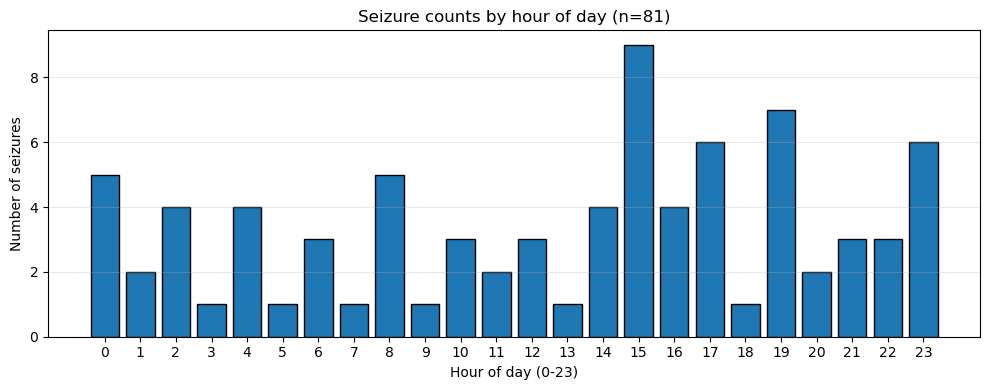

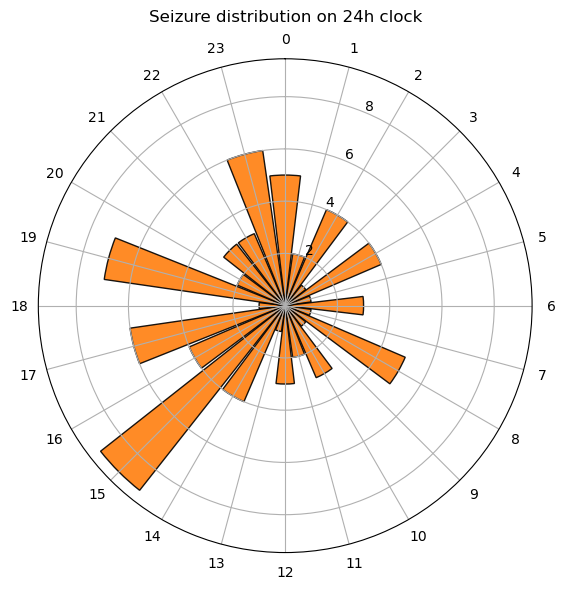

In [46]:
from scipy.stats import chi2

# Plot seizure counts by clock hour (bar + polar "clock" view) and do a simple uniformity check.
# Uses existing variables in the notebook (prefers `included_df` with 'best_start_hour').

# choose dataframe with best_start_hour
if 'included_df' in globals() and 'best_start_hour' in included_df.columns:
    df_hours = included_df['best_start_hour'].dropna().astype(int)
elif 'ann_responders' in globals():
    # fallback: compute best_start_hour from ann_responders
    tmp = ann_responders.copy()
    tmp['best_start'] = tmp[['start_eeg', 'start_clinic', 'end_eeg', 'end_clinic']].apply(
        lambda r: r.dropna().iloc[0] if r.notna().any() else pd.NaT, axis=1)
    df_hours = tmp['best_start'].dt.hour.dropna().astype(int)
elif 'ann_all' in globals():
    tmp = ann_all.copy()
    tmp['best_start'] = tmp[['start_eeg', 'start_clinic', 'end_eeg', 'end_clinic']].apply(
        lambda r: r.dropna().iloc[0] if r.notna().any() else pd.NaT, axis=1)
    df_hours = tmp['best_start'].dt.hour.dropna().astype(int)
else:
    raise RuntimeError("No suitable dataframe with seizure timestamps found (need included_df, ann_responders or ann_all).")

# counts per hour 0..23
counts = df_hours.value_counts().reindex(range(24), fill_value=0).sort_index()
total = int(counts.sum())

# simple bar chart
plt.figure(figsize=(10,4))
plt.bar(counts.index, counts.values, color='C0', edgecolor='k')
plt.xticks(range(24))
plt.xlabel('Hour of day (0-23)')
plt.ylabel('Number of seizures')
plt.title(f'Seizure counts by hour of day (n={total})')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# polar "clock" plot
angles = np.linspace(0, 2*np.pi, 24, endpoint=False)
width = 2*np.pi/24 * 0.9
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='polar')
bars = ax.bar(angles, counts.values, width=width, bottom=0, color='C1', edgecolor='k', alpha=0.9)
# format like a clock: midnight at top, hours clockwise
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_xticks(angles)
ax.set_xticklabels([str(h) for h in range(24)])
ax.set_title('Seizure distribution on 24h clock', va='bottom')
plt.tight_layout()

# Summary stats and simple uniformity test (chi-square against uniform)
expected = total / 24.0
chi2_stat = ((counts - expected)**2 / expected).sum()
p_value = None
try:
    p_value = 1 - chi2.cdf(chi2_stat, df=23)
except Exception:
    p_value = None  # scipy not available

# top hours and night percentage (22:00-06:59)
top3 = counts.sort_values(ascending=False).head(3)
night_hours = list(range(22,24)) + list(range(0,7))
night_count = counts.loc[night_hours].sum()
night_pct = night_count / total * 100 if total else 0.0

print(f"Total seizures used: {total}")
print("Top hours (hour:count):")
for h, c in top3.items():
    print(f"  {h}: {c}")
print(f"Seizures during night (22:00-07:00): {night_count} ({night_pct:.1f}%)")
print(f"Chi-square vs uniform: stat={chi2_stat:.2f}" + (f", p={p_value:.3f}" if p_value is not None else ", p=unknown (scipy not available)"))

# Interpretation hint:
# - If p-value < 0.05, the hourly distribution differs significantly from uniform (i.e. time-of-day likely matters).
# - If p-value is large (or if counts are fairly even), there's little evidence of correlation with clock hour.